# <center> Microlocal analysis of the Learned-Primal Dual </center>

In this notebook we present the final form of our software to compute the microlocal behavior of the Learned Primal-Dual algorithm.

## Utilitary libraries

In [1]:
%matplotlib inline
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import sys
sys.path.append("../../WF_inpaint/")

In [3]:
import adler
adler.util.gpu.setup_one_gpu(0)

Picking GPU 0


In [4]:
# Import the needed modules
from data.data_factory import random_realphantom
from ellipse.ellipseWF_factory import plot_WF, WFupdate, WFupdate_sino

import matplotlib.pyplot as plt
import numpy.random as rnd
import numpy as np
import odl
import matplotlib.pyplot as plt

../../WF_inpaint/data/data_factory.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/homes/extern/andra

../../WF_inpaint/realphantom/realphantomWF_factory.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/ho

In [5]:
from microlocal_lpd import (ellipt_layer_tf, ellipt_layer_numpy, grad_channel_batch,
                           WF_grad, WF_grad_channel_batch, ReLU, ReLU2, ReLU2_channel_batch,
                           ReLU_microlocal)

In [6]:
import tensorflow as tf
import numpy as np
import odl
import odl.contrib.tensorflow

In [7]:
np.random.seed(0)
#name = os.path.splitext(os.path.basename(__file__))[0]
name = os.path.splitext(os.getcwd())[0]+'/checkpoints'

In [8]:
sess = tf.InteractiveSession()

## Radon transform

In [9]:
size = 256
lowd = 40

In [10]:
from ray_transform.canon_relation import (point_img2sino, class_img2sino, CanRel_img2sino, 
                                         point_sino2img, CanRel_sino2img)

In [11]:
# Create ODL data structures
space = odl.uniform_discr([-int(size/2), -int(size/2)], [int(size/2), int(size/2)], [size, size],
                          dtype='float32')

In [12]:
# Full dose radon transform
geometry = odl.tomo.parallel_beam_geometry(space, num_angles=180)
operator = odl.tomo.RayTransform(space, geometry)
opnorm = odl.power_method_opnorm(operator)
operator = (1 / opnorm) * operator

In [13]:
# Low dose radon transform
geometry_lowd = odl.tomo.parallel_beam_geometry(space, num_angles=lowd)
operator_lowd = odl.tomo.RayTransform(space, geometry_lowd)
opnorm_lowd = odl.power_method_opnorm(operator_lowd)
operator_lowd = (1 / opnorm_lowd) * operator_lowd

## Data generator for CT recon

In [14]:
size = 256
nClasses = 180
lowd = 40
nRegions = np.random.randint(5,10)
npoints_max = np.random.randint(8,15)

In [15]:
batch_size = 5
n_iter = 10
n_primal = 5
n_dual = 5

In [16]:
def generate_data_CT(validation=False):
    """Generate a set of random data."""
    if validation:
        n_generate = 1
    else: 
        n_generate = batch_size

    y_arr = np.empty((n_generate, operator_lowd.range.shape[0], operator_lowd.range.shape[1], 1), dtype='float32')
    x_true_arr = np.empty((n_generate, space.shape[0], space.shape[1], 1), dtype='float32')

    for i in range(n_generate):
        if validation:
            phantom = odl.phantom.shepp_logan(space, True)
        else:
            phantom, _, _,  _ = random_realphantom(size, nRegions, npoints_max, nClasses)
        data = operator_lowd(phantom)
        noisy_data = data + odl.phantom.white_noise(operator_lowd.range) * np.mean(np.abs(data)) * 0.05

        x_true_arr[i, ..., 0] = phantom
        y_arr[i, ..., 0] = noisy_data

    return y_arr, x_true_arr

In [17]:
y_arr, x_true_arr = generate_data_CT()

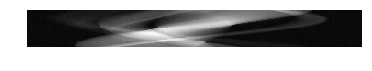

In [18]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(y_arr[0,:,:,0], cmap="gray")

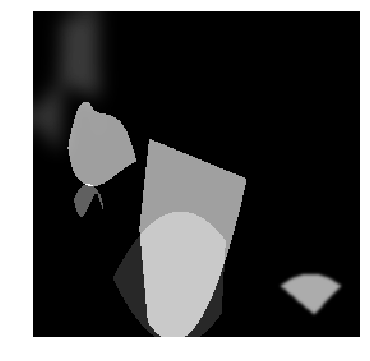

In [19]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(x_true_arr[0,:,:,0], cmap="gray")

## Evaluate learned primal-dual

In [20]:
# Create tensorflow layer from odl operator
odl_op_layer = odl.contrib.tensorflow.as_tensorflow_layer(operator_lowd,
                                                          'RayTransform')
odl_op_layer_adjoint = odl.contrib.tensorflow.as_tensorflow_layer(operator_lowd.adjoint,
                                                                  'RayTransformAdjoint')

In [21]:
with tf.name_scope('placeholders'):
    x_true = tf.placeholder(tf.float32, shape=[None, size, size, 1], name="x_true")
    y_rt = tf.placeholder(tf.float32, shape=[None, operator_lowd.range.shape[0], operator_lowd.range.shape[1], 1], name="y_rt")
    is_training = tf.placeholder(tf.bool, shape=(), name='is_training')

In [22]:
def apply_conv(x, filters=32):
    return tf.layers.conv2d(x, filters=filters, kernel_size=3, padding='SAME',
                            kernel_initializer=tf.contrib.layers.xavier_initializer(), use_bias=False)

In [23]:
primal_values = []
dual_values = []

In [24]:
relu = tf.nn.relu

In [25]:
with tf.name_scope('tomography'):
    with tf.name_scope('initial_values'):
        primal = tf.concat([tf.zeros_like(x_true)] * n_primal, axis=-1)
        dual = tf.concat([tf.zeros_like(y_rt)] * n_dual, axis=-1)

    for i in range(n_iter):
        with tf.variable_scope('dual_iterate_{}'.format(i)):
            evalop = odl_op_layer(primal[..., 1:2])
            update = tf.concat([dual, evalop, y_rt], axis=-1)

            #update = prelu(apply_conv(update), name='prelu_1')
            #update = prelu(apply_conv(update), name='prelu_2')
            update = relu(apply_conv(update), name='relu_1')
            update = relu(apply_conv(update), name='relu_2')            
            update = apply_conv(update, filters=n_dual)
            dual = dual + update

        with tf.variable_scope('primal_iterate_{}'.format(i)):
            evalop = odl_op_layer_adjoint(dual[..., 0:1])
            update = tf.concat([primal, evalop], axis=-1)

            update = relu(apply_conv(update), name='relu_1')
            update = relu(apply_conv(update), name='relu_2')
            update = apply_conv(update, filters=n_primal)
            primal = primal + update
        
        primal_values.append(primal)
        dual_values.append(dual)

    x_result = primal[..., 0:1]

In [26]:
# Initialize all TF variables
sess.run(tf.global_variables_initializer())

In [27]:
ckp_name = name+'_lpd_nobias/checkpoints'

In [28]:
adler.tensorflow.util.default_checkpoint_path(ckp_name)

'/store/kepler/datastore/andrade/GitHub_repos/Joint_CTWF_Recon/Microcanonical_NN/Tensorflow_microlocal/checkpoints_lpd_nobias/checkpoints.ckpt'

In [29]:
# Add op to save and restore
saver = tf.train.Saver()

if 1:
    saver.restore(sess,
                  adler.tensorflow.util.default_checkpoint_path(ckp_name))

INFO:tensorflow:Restoring parameters from /store/kepler/datastore/andrade/GitHub_repos/Joint_CTWF_Recon/Microcanonical_NN/Tensorflow_microlocal/checkpoints_lpd_nobias/checkpoints.ckpt


In [30]:
# Generate validation data
y_arr_validate, x_true_arr_validate = generate_data_CT(validation=True)

primal_values_result, dual_values_result = sess.run([primal_values, dual_values],
                      feed_dict={x_true: x_true_arr_validate,
                                 y_rt: y_arr_validate,
                                 is_training: False})

In [31]:
import matplotlib.pyplot as plt
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr

print(ssim(primal_values_result[-1][0, ..., 0], x_true_arr_validate[0, ..., 0]))
print(psnr(primal_values_result[-1][0, ..., 0], x_true_arr_validate[0, ..., 0], data_range=1))

0.986987719406
34.1344250283


/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """
/homes/extern/andrade/store/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  


(-0.5, 364.5, 39.5, -0.5)

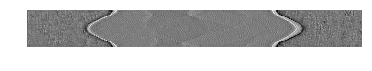

In [35]:
plt.figure(figsize=(6,6))
plt.imshow(dual_values_result[3][0, ..., 0], cmap="gray")
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

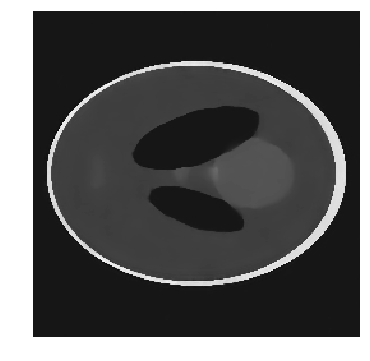

In [36]:
plt.figure(figsize=(6,6))
plt.imshow(primal_values_result[9][0, ..., 0], cmap="gray")
plt.axis('off')

## Microlocal analysis of the Learned Primal-Dual

### Getting the variables

In [ ]:
primal_values_result[2].shapedd

In [34]:
tf.global_variables()

[<tf.Variable 'dual_iterate_0/conv2d/kernel:0' shape=(3, 3, 7, 32) dtype=float32_ref>,
 <tf.Variable 'dual_iterate_0/conv2d_1/kernel:0' shape=(3, 3, 32, 32) dtype=float32_ref>,
 <tf.Variable 'dual_iterate_0/conv2d_2/kernel:0' shape=(3, 3, 32, 5) dtype=float32_ref>,
 <tf.Variable 'primal_iterate_0/conv2d/kernel:0' shape=(3, 3, 6, 32) dtype=float32_ref>,
 <tf.Variable 'primal_iterate_0/conv2d_1/kernel:0' shape=(3, 3, 32, 32) dtype=float32_ref>,
 <tf.Variable 'primal_iterate_0/conv2d_2/kernel:0' shape=(3, 3, 32, 5) dtype=float32_ref>,
 <tf.Variable 'dual_iterate_1/conv2d/kernel:0' shape=(3, 3, 7, 32) dtype=float32_ref>,
 <tf.Variable 'dual_iterate_1/conv2d_1/kernel:0' shape=(3, 3, 32, 32) dtype=float32_ref>,
 <tf.Variable 'dual_iterate_1/conv2d_2/kernel:0' shape=(3, 3, 32, 5) dtype=float32_ref>,
 <tf.Variable 'primal_iterate_1/conv2d/kernel:0' shape=(3, 3, 6, 32) dtype=float32_ref>,
 <tf.Variable 'primal_iterate_1/conv2d_1/kernel:0' shape=(3, 3, 32, 32) dtype=float32_ref>,
 <tf.Variable '

In [35]:
# Get access to the graph
gr = tf.get_default_graph()

In [36]:
names_variables = [variable.name for variable in tf.global_variables()]

###  Generate data with wavefront set

In [43]:
size = 256
nClasses = 180
lowd = 40

In [44]:
nRegions = np.random.randint(5,10)
npoints_max = np.random.randint(8,15)
realphantom, WFpoints, WFclasses,  WFimage = random_realphantom(size, nRegions, npoints_max, nClasses)

# Compute low dose WF image
angles_lowd = np.array([i for i in range(0,180,int(180/lowd))])
# Extracting the wavefront set orientations in the low dose
angles_gt = (np.array(WFclasses).astype(int)[:,0]-1)
angles_gt_lowd = np.array([angle in angles_lowd for angle in angles_gt])
# Generating the new WFpoints and classes
WFpoints_lowd = WFpoints[angles_gt_lowd]
WFclasses_lowd = list(np.array(WFclasses)[angles_gt_lowd])
# Generating the low dose WFimage
WFimage_lowd = np.zeros([size,size])
WFimage_lowd = WFupdate(WFpoints_lowd, WFclasses_lowd, WFimage_lowd)

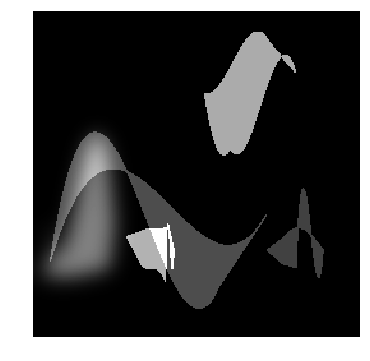

In [45]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(realphantom, cmap="gray")
plt.savefig('results/cartoon-like-phantom.png', transparent = True, bbox_inches = 'tight', pad_inches = 0)

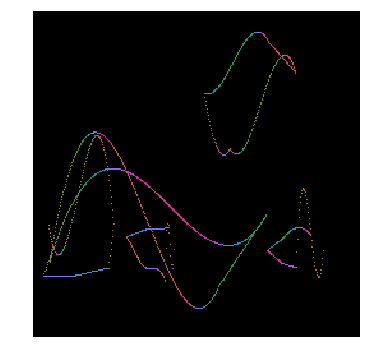

In [46]:
plt.figure(figsize = (6,6))
plt.axis("off")
plot_WF(WFimage)
plt.savefig('results/cartoon-like-phantom-WFset.png', transparent = True, bbox_inches = 'tight', pad_inches = 0)

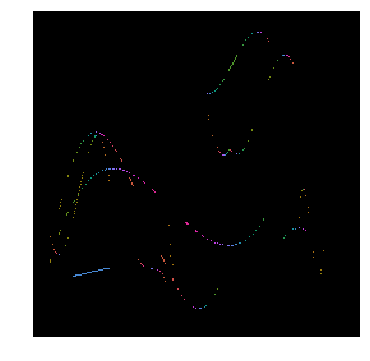

In [47]:
plt.figure(figsize = (6,6))
plt.axis("off")
plot_WF(WFimage_lowd)
plt.savefig('results/cartoon-like-WFset-lowd.png', transparent = True, bbox_inches = 'tight', pad_inches = 0)

In [48]:
# Full dose sinogram
sinogram = np.array(operator(space.element(realphantom)))
sinogram_shape = sinogram.shape
WFpoints_sino, WFclasses_sino = CanRel_img2sino(WFpoints, WFclasses, size, sinogram_shape, num_angles = 180)
WFimage_sino = np.zeros(sinogram.shape)
WFimage_sino = WFupdate_sino(WFpoints_sino, WFclasses_sino, WFimage_sino)

In [49]:
# Low dose sinogram
sinogram_lowd= np.array(operator_lowd(space.element(realphantom)))
sinogram_shape_lowd = sinogram_lowd.shape
WFpoints_sino_lowd, WFclasses_sino_lowd = CanRel_img2sino(WFpoints_lowd, WFclasses_lowd, size, sinogram_shape_lowd, num_angles = 180)
WFpoints_sino_lowd[:,1] = lowd* WFpoints_sino_lowd[:,1]/180
WFimage_sino_lowd = np.zeros(sinogram_lowd.shape)
WFimage_sino_lowd = WFupdate_sino(WFpoints_sino_lowd, WFclasses_sino_lowd, WFimage_sino_lowd)

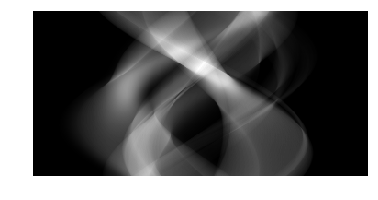

In [50]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(sinogram , cmap="gray")
plt.savefig('results/cartoon-like-sinogram.png', transparent = True, bbox_inches = 'tight', pad_inches = 0)

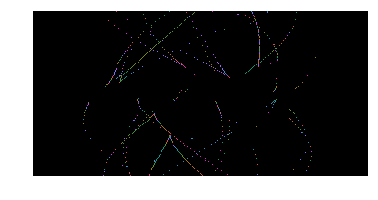

In [51]:
plt.figure(figsize = (6,6))
plt.axis("off")
plot_WF((180*WFimage_sino)%180)
plt.savefig('results/cartoon-like-sinogram-WFset.png', transparent = True, bbox_inches = 'tight', pad_inches = 0)

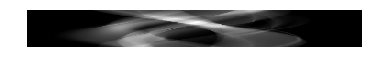

In [52]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(sinogram_lowd , cmap="gray")
plt.savefig('results/cartoon-like-sinogram-lowd.png', transparent = True, bbox_inches = 'tight', pad_inches = 0)

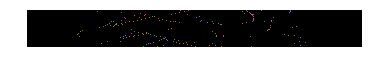

In [53]:
plt.figure(figsize = (6,6))
plt.axis("off")
plot_WF((100*WFimage_sino_lowd)%180)
plt.savefig('results/cartoon-like-sinogram-lowd-WFset.png', transparent = True, bbox_inches = 'tight', pad_inches = 0)

## First iterate

In [54]:
iterate = 0
conv_layer = 0
dual_layer = True

In [49]:
## Defining intial values
sinogram_lowd_tf = tf.constant(sinogram_lowd[np.newaxis, :,:, np.newaxis],
                              dtype = tf.float32)
realphantom_tf = tf.constant(realphantom[np.newaxis, :,:, np.newaxis],
                              dtype = tf.float32);

# Initial values of the recon and data
x_true = realphantom_tf 
y_rt = sinogram_lowd_tf;

# Initial value of the primal, dual, update, evalop
primal = tf.concat([tf.zeros_like(x_true)] * n_primal, axis=-1)
dual = tf.concat([tf.zeros_like(y_rt)] * n_dual, axis=-1)
evalop = odl_op_layer(primal[..., 1:2])
update = tf.concat([dual, evalop, y_rt], axis=-1)

# Initial value of WFset
WFset = WFimage_sino_lowd

In [50]:
radon = operator_lowd
n_batch = update.shape[0]
n_channels =  32
WFset_f = np.repeat(WFset[np.newaxis,:,:],n_batch, axis=0)
WFset_f = np.repeat(WFset_f[:,:,:, np.newaxis],n_channels, axis=3)

#### Microcanonical relation of the ReLU

In [51]:
name_kernel, conv_relu_1, WFset_ReLUf_1 = ReLU_microlocal(update, radon, WFset_f, gr, iterate, conv_layer, dual_layer)

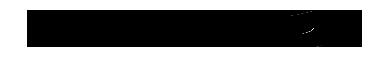

In [52]:
plt.figure(figsize = (6,6))
plt.axis("off")
plt.imshow(conv_relu_1.eval()[0,:,:,0], cmap="gray")

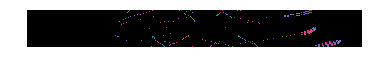

In [53]:
plt.figure(figsize = (6,6))
plt.axis("off")
plot_WF((180*WFset_ReLUf_1[0,:,:,0])%180)

#### Ellipticity of convolutional layer

In [54]:
# Let us define the matrix for the change of coordinates
A = np.array([
    [0, 0, 0,  0, 1, 1, 0, 1, -1],
    [0, 1, -1, 0, 0, -2, 0, 0, 2],
    [0, 0, 0, 0, -1, 1, 0, -1, -1],
    [0, 0, 0, 1, 0, 0, 1, -2, 2],
    [1, 0, 2, 0, 0, 0, -2, 0, -4],
    [0, 0, 0, -1, 0, 0, 1, 2, 2],
    [0, 0, 0, 0, -1, -1, 0, 1, -1],
    [0, -1, -1, 0, 0, 2, 0, 0, 2],
    [0, 0, 0, 0, 1, -1, 0, -1, -1]
])

# Inverse
Ainv = np.linalg.inv(A)

In [55]:
ellipt_layer_numpy(name_kernel, Ainv, radon, gr)

0.033424441583130307

#### Microcanonical relation of the Radon transform

In [56]:
WFset = (WFset_ReLUf_1[0,:,:,0])

In [57]:
WFpoints_sino = np.concatenate([np.where(WFset!=0)[1][:,np.newaxis],
                           np.where(WFset!=0)[0][:,np.newaxis]], axis = 1)

In [58]:
WFclasses_sino = [np.array([int(round(WFset[WFpoints_sino[i,1],WFpoints_sino[i,0]]))]) 
                  for i in range(WFpoints_sino.shape[0])]

In [59]:
## Upscaling WFpoints_sino_lowd
WFpoints_sino_up = WFpoints_sino.copy()
WFpoints_sino_up[:,1] = WFpoints_sino_up[:,1]*180/lowd
WFclasses_sino_up = WFclasses_sino

In [60]:
WFpoints_canon, WFclasses_canon = CanRel_sino2img(WFpoints_sino_up, WFclasses_sino_up, size, (180,sinogram_shape[1]) , num_angles = lowd)
WFpoints_canon = WFpoints_canon.astype(int)

In [61]:
indxs_inside = ((WFpoints_canon[:,0]<=size)*(WFpoints_canon[:,1]<=size)
               *(WFpoints_canon[:,0]>0)*(WFpoints_canon[:,1]>0))

In [62]:
WFpoints_canon = WFpoints_canon[indxs_inside]
WFclases_canon = list(np.array(WFclasses_canon)[indxs_inside])

In [ ]:
WFimage_canon = np.zeros([size,size])
WFimage_canon = WFupdate(WFpoints_canon, WFclasses_canon, WFimage_canon)

## Paper figures

Saving the data

In [83]:
import h5py

In [84]:
with h5py.File('data_LPD_micro.h5', 'w') as hf:
    hf.create_dataset("realphantom", data = realphantom)
    hf.create_dataset("WFimage",  data = WFimage)
    hf.create_dataset("WFimage_lowd",  data = WFimage_lowd)
    hf.create_dataset("sinogram",  data = sinogram)
    hf.create_dataset("WFimage_sino",  data = WFimage_sino)
    hf.create_dataset("WFimage_sino_lowd",  data = WFimage_sino_lowd)
    hf.create_dataset("sinogram_lowd",  data = sinogram_lowd)

In [86]:
hf = h5py.File('data_LPD_micro.h5', 'r')

In [95]:
hf.close()

In [94]:
with h5py.File('data_LPD_micro.h5', 'r') as hf:
    aver = hf['realphantom'][:]

### Reconstruction step

In [56]:
# Generate validation data
## Defining intial values
sinogram_lowd_tf = tf.constant(sinogram_lowd[np.newaxis, :,:, np.newaxis],
                              dtype = tf.float32)
realphantom_tf = tf.constant(realphantom[np.newaxis, :,:, np.newaxis],
                              dtype = tf.float32);

x_true_arr_validate = realphantom_tf.eval()
y_arr_validate = sinogram_lowd_tf.eval();

primal_values_result, dual_values_result = sess.run([primal_values, dual_values],
                      feed_dict={x_true: x_true_arr_validate,
                                 y_rt: y_arr_validate,
                                 is_training: False})

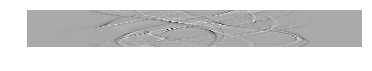

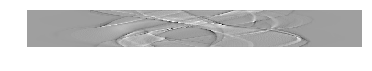

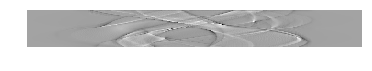

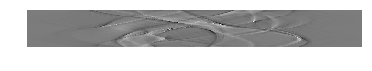

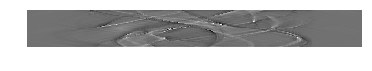

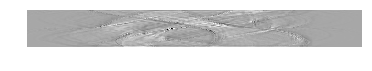

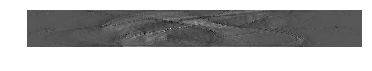

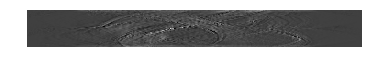

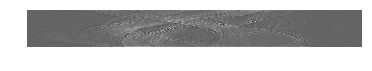

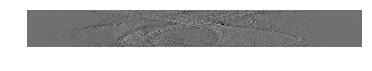

In [65]:
iterate = 0
for iterate in range(10):
    plt.figure(figsize=(6,6))
    plt.imshow(dual_values_result[iterate][0, ..., 0], cmap="gray")
    plt.axis('off')
    plt.savefig('results/dual_iteration_'+str(iterate)+'.png', transparent = True, bbox_inches = 'tight', pad_inches = 0)

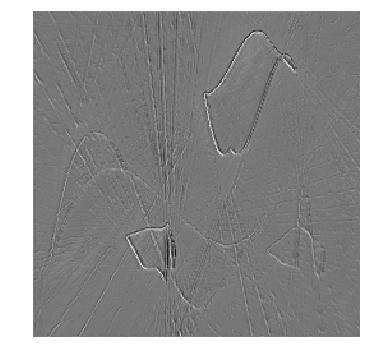

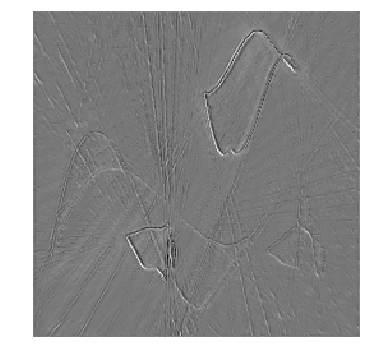

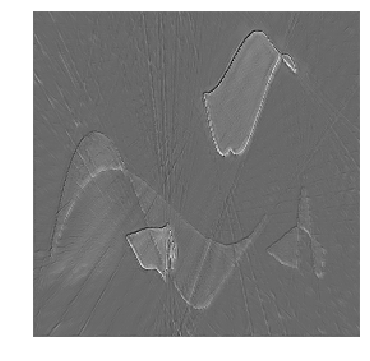

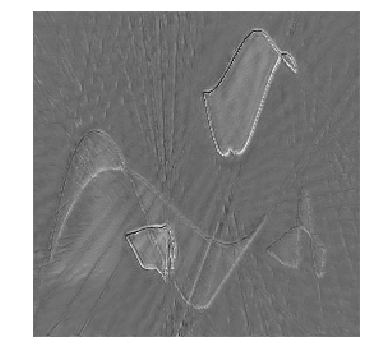

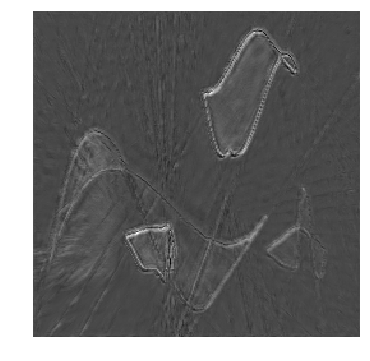

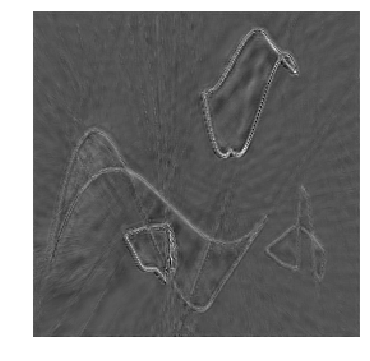

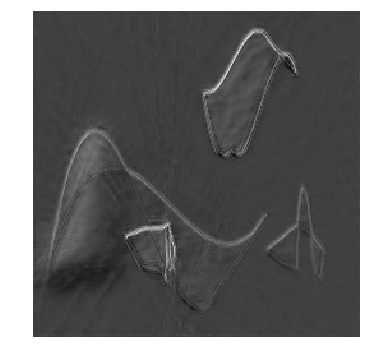

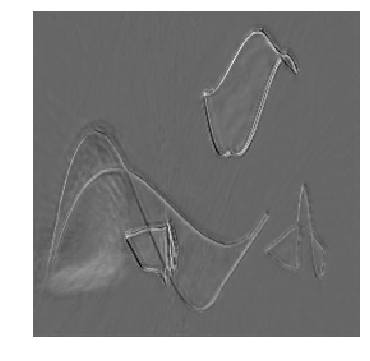

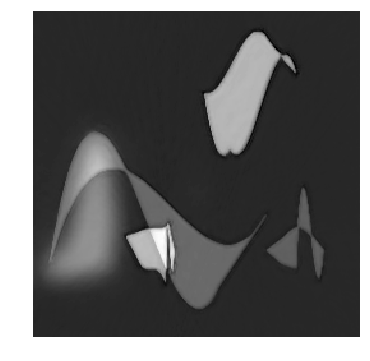

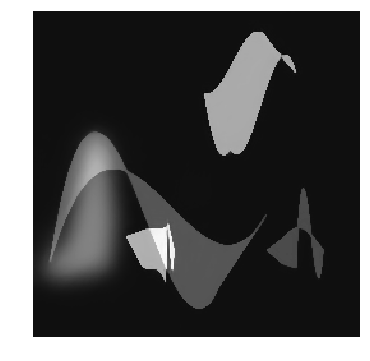

In [66]:
iterate = 0
for iterate in range(10):
    plt.figure(figsize=(6,6))
    plt.imshow(primal_values_result[iterate][0, ..., 0], cmap="gray")
    plt.axis('off')
    plt.savefig('results/primal_iteration_'+str(iterate)+'.png', transparent = True, bbox_inches = 'tight', pad_inches = 0)

## Wavefront set 